In [150]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import altair as alt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
from math import *
from sklearn.metrics import mean_squared_error

In [2]:
sales_df = pd.read_csv("./sales.csv",sep=";")
categories_df = pd.read_csv("./categories.csv",sep=";")
traffic_df = pd.read_csv("./traffic.csv",sep=";")

In [3]:
sales_df.head()

,week_starting_date,product_id,sales
0,20191209,1990,1
1,20201123,1990,1
2,20201207,1990,1
3,20191202,1990,1
4,20201109,1990,2


In [4]:
categories_df.head()

,product_id,category_id
0,1990,0
1,2361,1
2,1085,2
3,3091,3
4,955,4


In [5]:
traffic_df.head()

,week_starting_date,product_id,traffic
0,20190107,1990,1
1,20190107,2361,7
2,20190107,1085,1
3,20190107,3091,4
4,20190107,955,12


In [6]:
df = sales_df.merge(categories_df, on='product_id', how='inner').merge(traffic_df, on='product_id', how='inner')
df.head()

,week_starting_date_x,product_id,sales,category_id,week_starting_date_y,traffic
0,20191209,1990,1,0,20190107,1
1,20191209,1990,1,0,20190121,1
2,20191209,1990,1,0,20190218,1
3,20191209,1990,1,0,20190325,1
4,20191209,1990,1,0,20190408,1


In [7]:
df.rename(columns={'week_starting_date_x':'week_starting_date_sales',
                   'week_starting_date_y':'week_starting_date_traffic'},inplace=True)

In [8]:
df.describe()

,week_starting_date_sales,product_id,sales,category_id,week_starting_date_traffic,traffic
count,8.404080e+06,8.404080e+06,8.404080e+06,8.404080e+06,8.404080e+06,8.404080e+06
mean,2.019607e+07,1.529987e+03,2.966780e+01,2.572863e+01,2.019620e+07,2.316073e+01
std,4.978939e+03,9.031579e+02,1.003518e+02,1.876078e+01,4.977439e+03,8.162615e+01
min,2.019011e+07,1.000000e+00,1.000000e+00,0.000000e+00,2.019011e+07,1.000000e+00
25%,2.019080e+07,7.270000e+02,5.000000e+00,1.000000e+01,2.019073e+07,3.000000e+00
50%,2.020013e+07,1.513000e+03,9.000000e+00,2.200000e+01,2.020021e+07,7.000000e+00
75%,2.020072e+07,2.292000e+03,2.200000e+01,3.600000e+01,2.020073e+07,1.700000e+01
max,2.020123e+07,3.135000e+03,5.465000e+03,9.100000e+01,2.020123e+07,9.914000e+03


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8404080 entries, 0 to 8404079
Data columns (total 6 columns):
 #   Column                      Dtype
---  ------                      -----
 0   week_starting_date_sales    int64
 1   product_id                  int64
 2   sales                       int64
 3   category_id                 int64
 4   week_starting_date_traffic  int64
 5   traffic                     int64
dtypes: int64(6)
memory usage: 448.8 MB


In [10]:
df.head()

,week_starting_date_sales,product_id,sales,category_id,week_starting_date_traffic,traffic
0,20191209,1990,1,0,20190107,1
1,20191209,1990,1,0,20190121,1
2,20191209,1990,1,0,20190218,1
3,20191209,1990,1,0,20190325,1
4,20191209,1990,1,0,20190408,1


In [11]:
df2 = df.copy(deep=True)

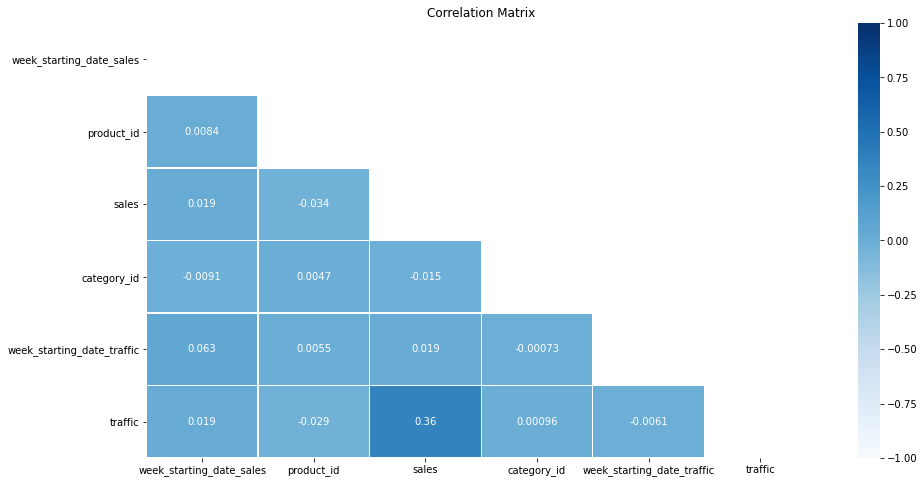

In [12]:
plt.figure(figsize=(15,8))
corr = df2.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True,linewidths=0.2,vmin=-1,vmax=1,mask=mask, cmap='Blues',center=0)
plt.title('Correlation Matrix')
plt.show()

In [13]:
df2['week_starting_date_sales'] = pd.to_datetime(df2['week_starting_date_sales'], format='%Y%m%d')
df2['week_starting_date_traffic'] = pd.to_datetime(df2['week_starting_date_traffic'], format='%Y%m%d')

In [14]:
df2['year_sales'] = df2['week_starting_date_sales'].dt.year
df2['month_sales'] = df2['week_starting_date_sales'].dt.month
df2['day_sales'] = df2['week_starting_date_sales'].dt.day
df2['year_traffic'] = df2['week_starting_date_traffic'].dt.year
df2['month_traffic'] = df2['week_starting_date_traffic'].dt.month
df2['day_traffic'] = df2['week_starting_date_traffic'].dt.day

<AxesSubplot:title={'center':'Sales by Year'}, xlabel='Years', ylabel='Sales in billions'>

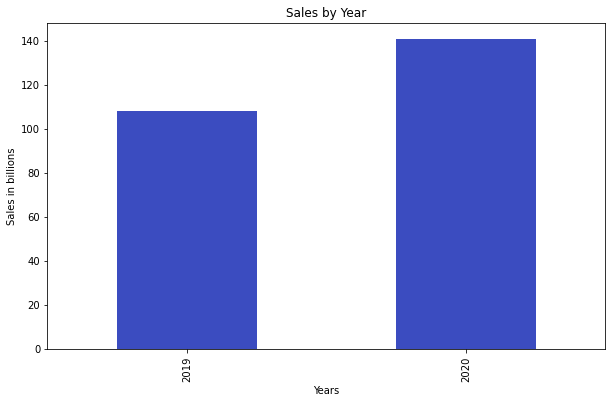

In [15]:
sales_year = df2.groupby('year_sales').agg(sales_target =('sales','sum'))
sales_year=sales_year/1000000
sales_year.plot(kind='bar', title = 'Sales by Year', figsize = (10,6), cmap='coolwarm', xlabel="Years",ylabel="Sales in billions",legend=False)

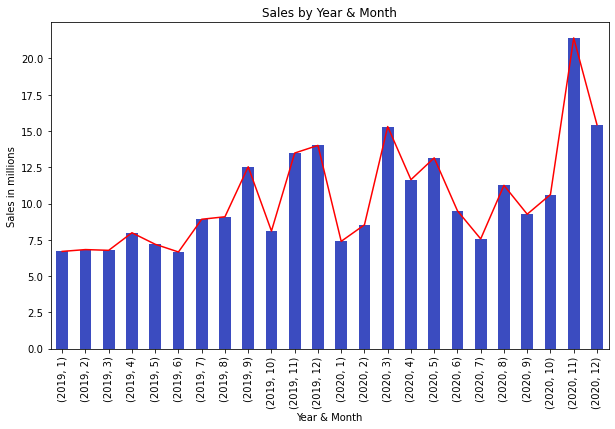

In [16]:
sales_year_month = df2.groupby(['year_sales','month_sales']).agg(sales_target =('sales','sum'))
sales_year_month=sales_year_month/1000000
ax=sales_year_month.plot(kind='line', title = 'Sales by Year & Month', figsize = (10,6), color='red', xlabel="Year & Month",ylabel="Sales in millions",legend=False)
sales_year_month.plot(kind='bar', title = 'Sales by Year & Month', figsize = (10,6), cmap='coolwarm', xlabel="Year & Month",ylabel="Sales in millions",legend=False,ax=ax);

<AxesSubplot:title={'center':'Best 10 selling product_id'}, xlabel='Product ID', ylabel='Sales in millions'>

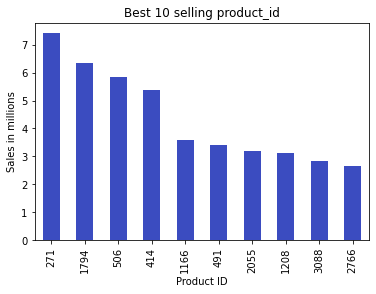

In [17]:
best_product = pd.DataFrame(df2.groupby('product_id').sum()['sales'])
best_product.sort_values(by=['sales'], inplace=True, ascending=False)
top_prods = best_product.head(10)
top_prods=top_prods/1000000
top_prods.plot(kind="bar", title = 'Best 10 selling product_id', cmap='coolwarm', xlabel="Product ID",ylabel="Sales in millions",legend=False)

<AxesSubplot:title={'center':'Best 10 selling category_id'}, xlabel='Category ID', ylabel='Sales in millions'>

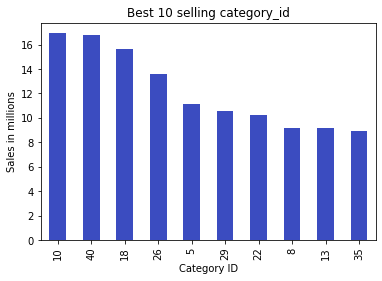

In [18]:
best_product = pd.DataFrame(df2.groupby('category_id').sum()['sales'])
best_product.sort_values(by=['sales'], inplace=True, ascending=False)
top_prods = best_product.head(10)
top_prods=top_prods/1000000
top_prods.plot(kind="bar", title = 'Best 10 selling category_id', cmap='coolwarm', xlabel="Category ID",ylabel="Sales in millions",legend=False)

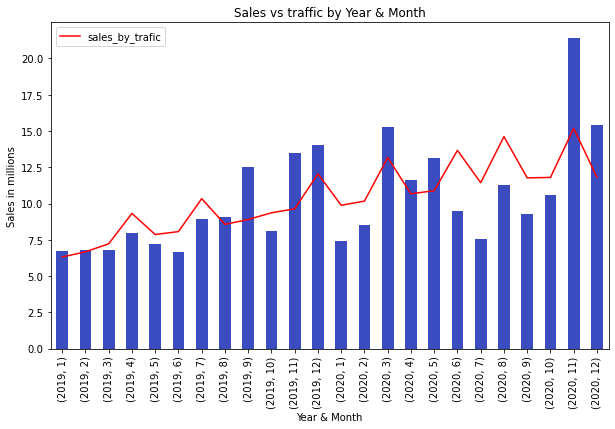

In [19]:
sales_year_month = df2.groupby(['year_sales','month_sales']).agg(sales_target =('sales','sum'))
trafiic_year_month = df2.groupby(['year_traffic','month_traffic']).agg(sales_by_trafic =('sales','sum'))
sales_year_month=sales_year_month/1000000
trafiic_year_month=trafiic_year_month/1000000
ax=trafiic_year_month.plot(kind='line', figsize = (10,6), color='red',ylabel="Sales in millions",)
sales_year_month.plot(kind='bar', title = 'Sales vs traffic by Year & Month', figsize = (10,6), cmap='coolwarm', xlabel="Year & Month",ylabel="Sales in millions",legend=False,ax=ax);

In [20]:
sales = df2.groupby(['year_sales','month_sales','day_sales']).agg(sales_target =('sales','sum'))
sales

sales_target
year_sales month_sales day_sales              
2019       1           7               1628218
                       14              1745566
                       21              1761404
                       28              1562678
           2           4               1787254
...                                        ...
2020       11          30              4654647
           12          7               5617549
                       14              5816397
                       21              1819454
                       28              2186564

[104 rows x 1 columns]

In [49]:
df2.groupby(['year_sales','month_sales','product_id']).agg({'sales': 'sum','traffic': 'sum'}).reset_index()

In [221]:
df.head()

,week_starting_date_sales,product_id,sales,category_id,week_starting_date_traffic,traffic
0,20191209,1990,1,0,20190107,1
1,20191209,1990,1,0,20190121,1
2,20191209,1990,1,0,20190218,1
3,20191209,1990,1,0,20190325,1
4,20191209,1990,1,0,20190408,1


In [250]:
#'product_id' 'traffic': 'sum'
data=df2.groupby(['week_starting_date_sales']).agg({'sales': 'sum'}).reset_index()
data = data.set_index('week_starting_date_sales')
data.head()

,sales
week_starting_date_sales,
2019-01-07,1628218
2019-01-14,1745566
2019-01-21,1761404
2019-01-28,1562678
2019-02-04,1787254


In [223]:
print("missing_data:", data.isna().sum())
print("unique dates:", data.index.nunique())

missing_data: sales      0
traffic    0
dtype: int64
unique dates: 104


## Visualise the data

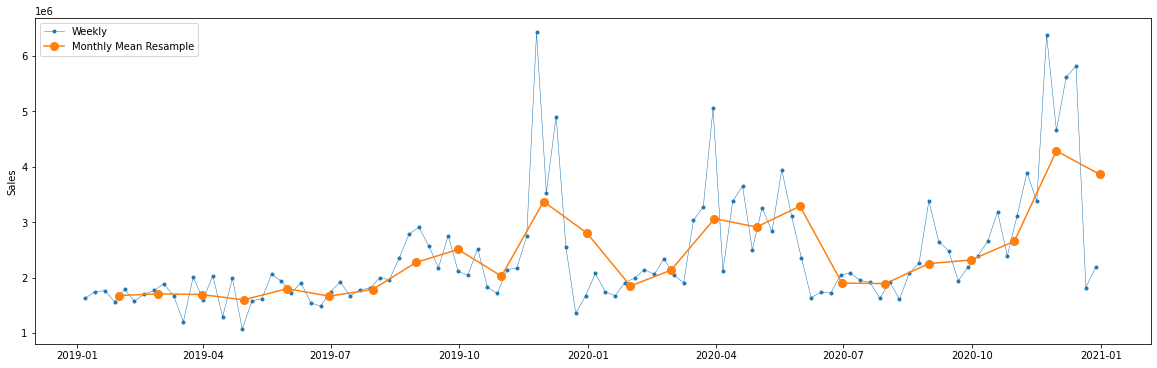

In [224]:
y = data[['sales']]
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Sales')
ax.legend();

In [225]:
#By looking at the graph of sales data above, we can see a general increasing trend with no clear pattern
#of seasonal or cyclical changes

Text(0, 0.5, 'Residual')

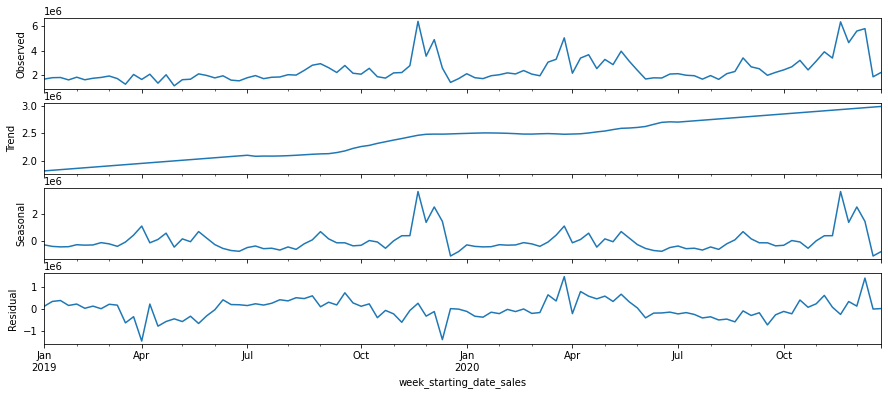

In [239]:
fig, axes = plt.subplots(4, 1, sharex=True,figsize=(15, 6))
decomposition.observed.plot(ax=axes[0], legend=False)
decomposition.trend.plot(ax=axes[1], legend=False)
decomposition.seasonal.plot(ax=axes[2], legend=False)
decomposition.resid.plot(ax=axes[3], legend=False)

axes[0].set_ylabel('Observed')
axes[1].set_ylabel('Trend')
axes[2].set_ylabel('Seasonal')
axes[3].set_ylabel('Residual')


In [227]:
#After looking at the four pieces of decomposed graphs, we can tell that our sales dataset has an overall increasing
#trend as well as a yearly seasonality.

## Check for stationarity

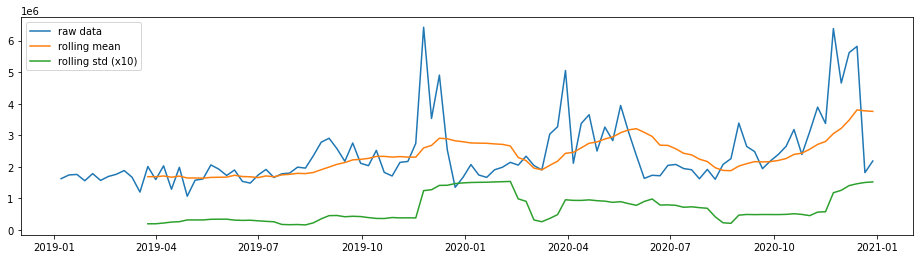

In [228]:
y = data['sales']
rolmean = pd.Series(y).rolling(window=12).mean() 
rolstd = pd.Series(y).rolling(window=12).std()   
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(y, label= 'raw data')
ax.plot(rolmean, label='rolling mean');
ax.plot(rolstd, label='rolling std (x10)');
ax.legend()

In [229]:
#Both the mean and standard deviation for stationary data does not change much over time But in this case, since the
#y-axis has such a large scale, we can not confidently conclude that our data is stationary by simply viewing the above graph.

In [230]:
y = data['sales']
print('Is the {} stationary ?'.format("Raw data"))
test = adfuller(y.dropna(), autolag='AIC')
print('Test statistic = {:.3f}'.format(test[0]))
print('P-value = {:.3f}'.format(test[1]))
print('Critical values :')
for k, v in test[4].items():
    print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<test[0] else '', 100-int(k[:-1])))

Is the Raw data stationary ?
Test statistic = -4.430
P-value = 0.000
Critical values :
	1%: -3.497501033 - The data is  stationary with 99% confidence
	5%: -2.89090644 - The data is  stationary with 95% confidence
	10%: -2.5824349 - The data is  stationary with 90% confidence


In [231]:
#The p-value is less than the significance level of 0.05 and hence we can reject the null hypothesis 
#and take that the series is stationary.

## Create Training & Testing Datasets

In [285]:
train = data[:'2020-05-04']
test = data['2020-05-04':] 
predict_date = len(y) - len(y[:'2020-05-04'])

,sales
week_starting_date_sales,
2020-11-30,4654647
2020-12-07,5617549
2020-12-14,5816397
2020-12-21,1819454
2020-12-28,2186564


## Holt Winters Model

In [288]:
hwmodel=ExponentialSmoothing(train.sales,trend='add', seasonal='add', seasonal_periods=2,).fit()

C:\Users\mikol\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
C:\Users\mikol\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [289]:
test_pred=hwmodel.forecast(35)
test_pred

2020-05-11   3229066.44871180
2020-05-18   2982537.57758828
2020-05-25   3204654.01708968
2020-06-01   2958125.14596615
2020-06-08   3180241.58546755
2020-06-15   2933712.71434403
2020-06-22   3155829.15384542
2020-06-29   2909300.28272190
2020-07-06   3131416.72222329
2020-07-13   2884887.85109977
2020-07-20   3107004.29060117
2020-07-27   2860475.41947765
2020-08-03   3082591.85897904
2020-08-10   2836062.98785552
2020-08-17   3058179.42735691
2020-08-24   2811650.55623339
2020-08-31   3033766.99573479
2020-09-07   2787238.12461127
2020-09-14   3009354.56411266
2020-09-21   2762825.69298914
2020-09-28   2984942.13249053
2020-10-05   2738413.26136701
2020-10-12   2960529.70086841
2020-10-19   2714000.82974489
2020-10-26   2936117.26924628
2020-11-02   2689588.39812276
2020-11-09   2911704.83762415
2020-11-16   2665175.96650063
2020-11-23   2887292.40600203
2020-11-30   2640763.53487850
2020-12-07   2862879.97437990
2020-12-14   2616351.10325638
2020-12-21   2838467.54275777
2020-12-28

<AxesSubplot:xlabel='week_starting_date_sales'>

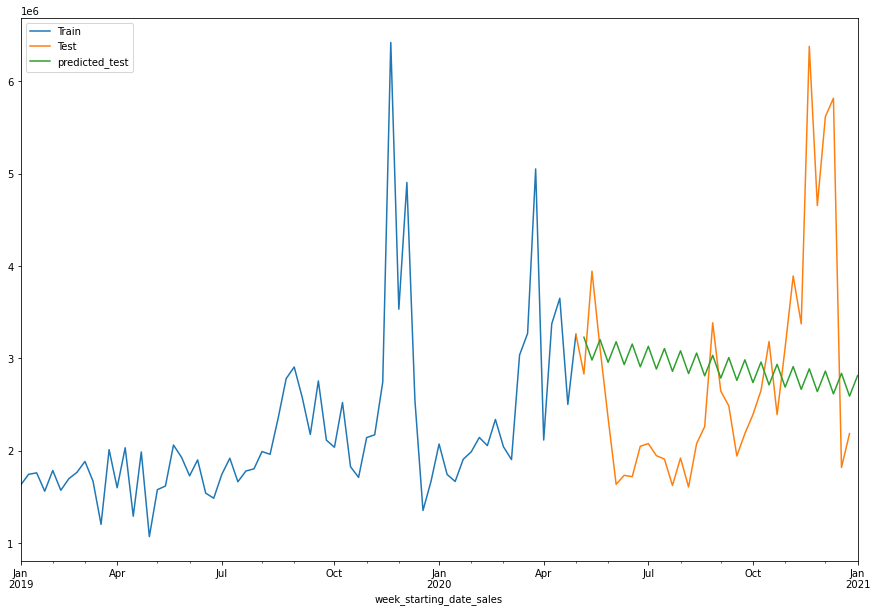

In [290]:
train['sales'].plot(legend=True, label='Train', figsize=(15,10))
test['sales'].plot(legend=True, label='Test')

test_pred.plot(legend=True, label='predicted_test')

In [291]:
print(test)
print(test_pred)

                            sales
week_starting_date_sales         
2020-05-04                3260502
2020-05-11                2831231
2020-05-18                3944640
2020-05-25                3110008
2020-06-01                2357643
2020-06-08                1637124
2020-06-15                1734461
2020-06-22                1719876
2020-06-29                2049091
2020-07-06                2078052
2020-07-13                1947459
2020-07-20                1910332
2020-07-27                1624601
2020-08-03                1921529
2020-08-10                1608250
2020-08-17                2078387
2020-08-24                2261007
2020-08-31                3386007
2020-09-07                2647533
2020-09-14                2485763
2020-09-21                1944255
2020-09-28                2187002
2020-10-05                2392166
2020-10-12                2652584
2020-10-19                3183421
2020-10-26                2391447
2020-11-02                3117809
2020-11-09    

In [275]:
sqrt(mean_squared_error(test,test_pred))

1275266.3060288564

In [292]:
df.sales.mean(), sqrt(df.sales.var())

(29.667798378882637, 100.35181419536285)

## Sarima 